#   TP3  - Sistema Dinâmico  de Inversores  
## Dezembro, 2022

Bruno Miguel Ferreira Fernandes - a95972

Hugo Filipe de Sá Rocha - a96463

Cada inversor tem um bit $s$ de estado, inicializado  com um valor aleatório.

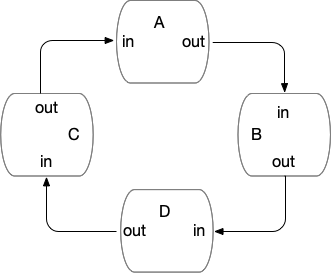

Cada inversor é regido pelas seguintes transformações

$$
\begin{array}{c}
invert(in,out)\\
x \gets \mathsf{read}(\mathtt{in})\\
s \gets \neg x\;\;\|\;\; s\gets s\oplus x\\
\mathsf{write}(\mathtt{out},s)\\
\end{array}
$$

In [22]:
from pysmt.shortcuts import *
from pysmt.typing import *

import random
import itertools

### Funções auxiliares:
- xor(b1,b2) - Aplica a operação de xor a 2 bits.

In [23]:
#xor entre 2 bits
def xor(b1,b2):
    if Equals(b1,b2):
        return 0
    else:
        return 1

Para modelar este programa como um SFOTS teremos o conjunto $\mathsf{X}$ de variáveis do estado dado pela lista `['pc', 't1', 't2', 't3', 't4', 'A', 'B', 'C', 'D']`, e definimos a função `genState` que recebe a lista com o nome das variáveis do estado, uma etiqueta e um inteiro, e cria a i-ésima cópia das variáveis do estado para essa etiqueta. As variáveis lógicas começam sempre com o nome de base das variáveis dos estado, seguido do separador `!`.

In [24]:
def genState(vars,s,i):
    state = {}
    for v in vars:
        state[v] = Symbol(v+'!'+s+str(i),INT)
    return state

A escolha neste comando é sempre determinística, isto é, em cada inversor a escolha do comando a executar é sempre a mesma. Porém essa escolha é determinada aleatoriamente na inicializarão do sistema.

In [25]:
#iniciar os 4 bits aleatoriamente
r1 = random.randint(0,1)
r2 = random.randint(0,1)
r3 = random.randint(0,1)
r4 = random.randint(0,1)


#iniciar escolha deterministica dos 4 inversores aleatoriamente
#0 -> s <- ~x   1-> s = xor(s,x)
aux = ['A','B','C','D']
escolhas = []

for i in range(4):
    r = random.randint(0,1)
    if r == 0:
        print(f'O inversor {aux[i]} tem a transformação s <- ~x.')
        escolhas.append(0)
    else:
        print(f'O inversor {aux[i]} tem a transformação s <- xor(s, x).')
        escolhas.append(1)

print('\n')

O inversor A tem a transformação s <- ~x.
O inversor B tem a transformação s <- ~x.
O inversor C tem a transformação s <- ~x.
O inversor D tem a transformação s <- xor(s, x).




Definimos as seguintes funções para completar a modelação deste programa:

- A função `init` dado um estado do programa (um dicionário de variáveis), devolve um predicado do pySMT que testa se esse estado é um possível estado inicial do programa.

In [26]:
def init(state):
    return And(Equals(state['t1'], Int(r1)), Equals(state['t2'], Int(r2)), 
               Equals(state['t3'], Int(r3)), Equals(state['t4'], Int(r4)),
               Equals(state['A'], Int(escolhas[0])), Equals(state['B'], Int(escolhas[1])),
               Equals(state['C'], Int(escolhas[2])), Equals(state['D'], Int(escolhas[3])),
               Equals(state['pc'], Int(0)))

- A função `error` dado um  estado do programa, devolve um predicado do pySMT que testa se esse estado é um possível estado de erro do programa.

O sistema termina em ERRO quando o estado do sistema for $(0,0,0,0)$.

In [27]:
def error(state):
    return And(Equals(state['t1'], Int(0)), Equals(state['t2'], Int(0)), 
               Equals(state['t3'], Int(0)), Equals(state['t4'], Int(0)))

- A função `trans` que, dados dois estados do programa, devolve um predicado do pySMT que testa se é possível transitar do primeiro para o segundo estado.

In [28]:
def trans(curr, prox):
    #Inversor A
    t1 = And(
        Equals(curr['pc'], Int(0)),
        Equals(curr['A'], Int(0)), #escolha negaçao
        Equals(curr['t4'], Int(1)),
        Equals(prox['t1'], Int(0)),
        Equals(prox['pc'], Int(1)),
        Equals(prox['t2'], curr['t2']),
        Equals(prox['t3'], curr['t3']),
        Equals(prox['t4'], curr['t4']),
        Equals(prox['A'], curr['A']),
        Equals(prox['B'], curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    
    t2 = And(
        Equals(curr['pc'], Int(0)),
        Equals(curr['A'], Int(0)), #escolha negaçao
        Equals(curr['t4'], Int(0)),
        Equals(prox['t1'], Int(1)),
        Equals(prox['pc'], Int(1)),
        Equals(prox['t2'], curr['t2']),
        Equals(prox['t3'], curr['t3']),
        Equals(prox['t4'], curr['t4']),
        Equals(prox['A'], curr['A']),
        Equals(prox['B'], curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    ) 
    
    
    t3 = And(
        Equals(curr['pc'], Int(0)),
        Equals(curr['A'],  Int(1)), #escolha s -> s + x
        Equals(prox['t1'],  Int(xor(prox['t1'],curr['t4']))),
        Equals(prox['pc'],  Int(1)),
        Equals(prox['t2'],  curr['t2']),
        Equals(prox['t3'],  curr['t3']),
        Equals(prox['t4'],  curr['t4']),
        Equals(prox['A'],  curr['A']),
        Equals(prox['B'],  curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    #Inversor B
    t4 = And(
        Equals(curr['pc'], Int(1)),
        Equals(curr['B'], Int(0)), #escolha negaçao
        Equals(prox['t1'], curr['t1']),
        Equals(prox['pc'], Int(2)),
        Equals(curr['t1'], Int(1)),
        Equals(prox['t2'], Int(0)),
        Equals(prox['t3'], curr['t3']),
        Equals(prox['t4'], curr['t4']),
        Equals(prox['A'], curr['A']),
        Equals(prox['B'], curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    t5 = And(
        Equals(curr['pc'], Int(1)),
        Equals(curr['B'], Int(0)), #escolha negaçao
        Equals(prox['t1'], curr['t1']),
        Equals(prox['pc'], Int(2)),
        Equals(curr['t1'], Int(0)),
        Equals(prox['t2'], Int(1)),
        Equals(prox['t3'], curr['t3']),
        Equals(prox['t4'], curr['t4']),
        Equals(prox['A'], curr['A']),
        Equals(prox['B'], curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    
    t6 = And(
        Equals(curr['pc'], Int(1)),
        Equals(curr['B'],  Int(1)), #escolha s -> s + x
        Equals(prox['t1'],  curr['t1']),
        Equals(prox['pc'],  Int(2)),
        Equals(prox['t2'],  Int(xor(prox['t2'],curr['t1']))),
        Equals(prox['t3'],  curr['t3']),
        Equals(prox['t4'],  curr['t4']),
        Equals(prox['A'],  curr['A']),
        Equals(prox['B'],  curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    
    #Inversor C
    t7 = And(
        Equals(curr['pc'], Int(2)),
        Equals(curr['C'], Int(0)), #escolha negaçao
        Equals(prox['t1'], curr['t1']),
        Equals(prox['pc'], Int(3)),
        Equals(prox['t2'], curr['t2']),
        Equals(curr['t2'], Int(1)),
        Equals(prox['t3'], Int(0)),
        Equals(prox['t4'], curr['t4']),
        Equals(prox['A'], curr['A']),
        Equals(prox['B'], curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    
    t8 = And(
        Equals(curr['pc'], Int(2)),
        Equals(curr['C'], Int(0)), #escolha negaçao
        Equals(prox['t1'], curr['t1']),
        Equals(prox['pc'], Int(3)),
        Equals(prox['t2'], curr['t2']),
        Equals(curr['t2'], Int(0)),
        Equals(prox['t3'], Int(1)),
        Equals(prox['t4'], curr['t4']),
        Equals(prox['A'], curr['A']),
        Equals(prox['B'], curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    
    t9 = And(
        Equals(curr['pc'], Int(2)),
        Equals(curr['C'],  Int(1)), #escolha s -> s + x
        Equals(prox['t1'],  curr['t1']),
        Equals(prox['pc'],  Int(3)),
        Equals(prox['t2'],  curr['t2']),
        Equals(prox['t3'],  Int(xor(prox['t3'],curr['t2']))),
        Equals(prox['t4'],  curr['t4']),
        Equals(prox['A'],  curr['A']),
        Equals(prox['B'],  curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    #Inversor D
    t10 = And(
        Equals(curr['pc'], Int(3)),
        Equals(curr['D'], Int(0)), #escolha negaçao
        Equals(prox['t1'], curr['t1']),
        Equals(prox['pc'], Int(0)),
        Equals(prox['t2'], curr['t2']),
        Equals(prox['t3'], curr['t3']),
        Equals(curr['t3'], Int(1)),
        Equals(prox['t4'], Int(0)),
        Equals(prox['A'], curr['A']),
        Equals(prox['B'], curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    t11 = And(
        Equals(curr['pc'], Int(3)),
        Equals(curr['D'], Int(0)), #escolha negaçao
        Equals(prox['t1'], curr['t1']),
        Equals(prox['pc'], Int(0)),
        Equals(prox['t2'], curr['t2']),
        Equals(prox['t3'], curr['t3']),
        Equals(curr['t3'], Int(0)),
        Equals(prox['t4'], Int(1)),
        Equals(prox['A'], curr['A']),
        Equals(prox['B'], curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    
    
    t12 = And(
        Equals(curr['pc'], Int(3)),
        Equals(curr['D'],  Int(1)), #escolha s -> s + x
        Equals(prox['t1'],  curr['t1']),
        Equals(prox['pc'],  Int(0)),
        Equals(prox['t2'],  curr['t2']),
        Equals(prox['t3'],  curr['t3']),
        Equals(prox['t4'],  Int(xor(prox['t4'],curr['t3']))),
        Equals(prox['A'],  curr['A']),
        Equals(prox['B'],  curr['B']),
        Equals(prox['C'], curr['C']),
        Equals(prox['D'], curr['D'])
    )
    
    return Or(t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12)

Seguindo esta notação, a fórmula 
$\;\mathsf{I}\,\land\,\mathsf{T}^n\,$ denota um traço finito com $\,n\,$ transições em $\Sigma\,$, $\,\mathsf{X}_0,\cdots,\mathsf{X}_n\,$, que descrevem estados acessíveis com $n$ ou menos transições. Inspirada nesta notação, a seguinte função `genTrace` gera um possível traço de execução com $n$ transições.

In [29]:
def genTrace(vars,init,trans,error,n):
    with Solver(name="z3") as s:
        
        X = [genState(vars,'X',i) for i in range(n+1)]#cria n+1 estados (com etiqueta X)
        I = init(X[0])
        Tks = [ trans(X[i],X[i+1]) for i in range(n) ]
        
        if s.solve([I, And(Tks)]):  # testa se I /\ T^n  é satisfazível
            for i in range(n+1):
                print("Passo:",i)
                for v in X[i]:
                    print("          ",v,'=',s.get_value(X[i][v]))
        else:
            print('unsat')

genTrace(['pc', 't1', 't2', 't3', 't4', 'A', 'B', 'C', 'D'], init, trans, error, 5)

Passo: 0
           pc = 0
           t1 = 1
           t2 = 0
           t3 = 1
           t4 = 0
           A = 0
           B = 0
           C = 0
           D = 1
Passo: 1
           pc = 1
           t1 = 1
           t2 = 0
           t3 = 1
           t4 = 0
           A = 0
           B = 0
           C = 0
           D = 1
Passo: 2
           pc = 2
           t1 = 1
           t2 = 0
           t3 = 1
           t4 = 0
           A = 0
           B = 0
           C = 0
           D = 1
Passo: 3
           pc = 3
           t1 = 1
           t2 = 0
           t3 = 1
           t4 = 0
           A = 0
           B = 0
           C = 0
           D = 1
Passo: 4
           pc = 0
           t1 = 1
           t2 = 0
           t3 = 1
           t4 = 0
           A = 0
           B = 0
           C = 0
           D = 1
Passo: 5
           pc = 1
           t1 = 1
           t2 = 0
           t3 = 1
           t4 = 0
           A = 0
           B = 0
           C = 0
           D = 

Definimos uma função de ordem superior `invert` que recebe a função python que codifica a relação de transição e devolve a relação e transição inversa.
Para auxiliar na implementação deste algoritmo, definimos ainda duas funções.
A função `rename` renomeia uma fórmula (sobre um estado) de acordo com um dado estado. 
A função `same` testa se dois estados são iguais.

In [30]:
def invert(trans):
    return (lambda c, p: trans(p,c))

def baseName(s):
    return ''.join(list(itertools.takewhile(lambda x: x!='!', s)))

def rename(form,state):
    vs = get_free_variables(form)
    pairs = [ (x,state[baseName(x.symbol_name())]) for x in vs ]
    return form.substitute(dict(pairs))

def same(state1,state2):
    return And([Equals(state1[x],state2[x]) for x in state1])

### O algoritmo de "model-checking"

O algoritmo de “model-checking” manipula as fórmulas $\;\mathsf{R}_n\;\equiv\; \mathsf{I}\,\land\,\mathsf{T}^n\;$ e $\;\mathsf{U}_m\equiv\; \mathsf{E}\,\land\,\mathsf{B}^m\;$ fazendo crescer os índices $\;n,m\;$ de acordo  com as seguintes regras

----------
1. Inicia-se $n=0$, $\;\mathsf{R}_0 = \mathsf{I}\;$ e $\;\mathsf{U}_0 = \mathsf{E}$.


2.  No estado $\,(n,m)\,$  tem-se a certeza que em todos os estados anteriores não foi detectada nenhuma justificação para a insegurança do SFOTS. 
    Se $\;\mathsf{V}_{n,m}\equiv\;\mathsf{R}_n\land(X_n=Y_m)\land\mathsf{U}_m\;$ é satisfazível o sistema é inseguro e o algoritmo termina com a mensagem **unsafe**.


3. Se $\;\mathsf{V}_{n,m}\equiv\;\mathsf{R}_n\land(X_n=Y_m)\land \mathsf{U}_m\;$ for insatisfazível calcula-se  $\;{C}\;$ como  o interpolante do par $\,(\mathsf{R}_n\land(X_n=Y_m)\,,\,\mathsf{U}_m)\,$.
     Neste caso verificam-se as tautologias    $\mathsf{R}_n \to C(X_n)\;$  e $\;\mathsf{U}_m\,\to\,\neg\, C(Y_m)\;$.


4. Testa-se a condição $\;\mathsf{SAT}(C\land\mathsf{T}\land\neg\,C')=\emptyset\;$  para verificar se  $\,C\,$ é um invariante de $\;\mathsf{T}\,$; se for invariante  então, pelo resultado anterior, sabe-se que $\,\mathsf{V}_{n',m'}\;$ é insatisfazível para todo $\,n'\ge n\,$ e $\,m'\ge n\,$. O algoritmo termina com a mensagem **safe**.


5. Se $\,C\,$ não for invariante de $\,\mathsf{T}\,$ procura-se encontrar um majorante $\,S \supseteq C$ que verifique as condições do resultado referido: seja um invariante de $\,\mathsf{T}$   disjunto de $\,\mathsf{U}_m\,$.


6. Se for possível encontrar tal majorante $\,S\,$ então o algoritmo termina com a mensagem **safe**. Se não for possível encontrar o majorante pelo menos um dos índices $\,n,m\,$ é incrementado, os valores das fórmulas $\,\mathsf{R}_n\,,\,\mathsf{U}_m\,$ são actualizados e repete-se o processo a partir do passo 2.

Definimos uma função de ordem superior `model-checking` que dada a lista de nomes das variáveis do sistema, um predicado que testa se um estado é inicial, um predicado que testa se um par de estados é uma transição válida, um predicado que testa se um estado é de erro, e dois números positivos N e M que são os limites máximos para os indices 𝑛 e 𝑚. Implementando o algoritmo iterativo que manipula as fórmulas $\;\mathsf{R}_n\;\equiv\; \mathsf{I}\,\land\,\mathsf{T}^n\;$ e $\;\mathsf{U}_m\equiv\; \mathsf{E}\,\land\,\mathsf{B}^m\;$ fazendo crescer os índices 𝑛,𝑚 de acordo com as regras acima apresentadas.

In [31]:
def model_checking(vars,init,trans,error,N,M):
    with Solver(name="z3") as s:

        # Criar todos os estados que poderão vir a ser necessários.
        X = [genState(vars,'X',i) for i in range(N+1)]
        Y = [genState(vars,'Y',i) for i in range(M+1)]
        
        # Estabelecer a ordem pela qual os pares (n,m) vão surgir. Por exemplo:
        order = sorted([(a,b) for a in range(1,N+1) for b in range(1,M+1)],
                       key=lambda tup:tup[0]+tup[1]) 
        
        for (n,m) in order:
            Tn = And([trans(X[i], X[i+1]) for i in range(n)])
            I = init(X[0]) 
            Rn = And(I, Tn)
            
            Bm = And([invert(trans)(Y[i], Y[i+1]) for i in range(m)])
            E = error(Y[0])
            Um = And(E, Bm)
            
            Vnm = And(Rn, same(X[n], Y[m]), Um)
                
            if s.solve([Vnm]):
                print("Unsafe")
                return
            else:# Vnm é instatisfazível
                C = binary_interpolant(And(Rn, same(X[n], Y[m])), Um)
                if C is None:
                    print("Interpolant None")
                    break
                C0 = rename(C, X[0])
                C1 = rename(C, X[1])
                T = trans(X[0], X[1])
                if not s.solve([C0, T, Not(C1)]):   # C é invariante de T
                    print("Safe")
                    return
                else:
                    S = rename(C, X[n])
                    while True:
                        A = And(S, trans(X[n], Y[m]))
                        if s.solve([A,Um]):
                            print("Não é possível encontrar um majorante")
                            break
                        else:
                            Cnew = binary_interpolant(A, Um)
                            Cn = rename(Cnew, X[n])
                            if s.solve([Cn, Not(S)]):  # Se Cn -> S não é tautologia
                                S = Or(S, Cn)
                            else:             # S foi encontrado
                                print("Safe")
                                return

model_checking(['pc', 't1', 't2', 't3', 't4', 'A', 'B', 'C', 'D'], 
               init, trans, error, 50, 50)

Não é possível encontrar um majorante
Não é possível encontrar um majorante
Não é possível encontrar um majorante
Não é possível encontrar um majorante
Não é possível encontrar um majorante
Não é possível encontrar um majorante
Safe
